## Pipeline Script 
This script 

### Import Packages

In [64]:
import os
import glob
import numpy as np
import pandas as pd
import network_fcon as fc
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Define paths and variables

In [65]:
# Set paths
inpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d"
outpath = "~/Desktop/ImageData/PMACS_remote/analysis/postprocessing/"
clinpath = "~/Desktop/ImageData/PMACS_remote/data/clinical"
cestpath = "/Users/pecsok/Desktop/ImageData/PMACS_remote/data/cest/preprocessed/"

# Choose what to analyse
networks = ["TempPar", "Default", "Vis"] 
CESTnetworks = ["CEST_TempPar", "CEST_Default", "CEST_Vis"]
CNB_scores = ["tap_tot"] #, "er40_cr"
CNB_valids = ["tap_valid"] #, "er40_valid"
diag_scores = ["hstatus"] # ,"axis1_desc1","axis1_stat1"
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]

# Make dataframe based on metrics of interest
#columns = ["BBLID"] + ["Session"] + networks
#fcon_df = pd.DataFrame(columns=columns)
#clin_df = pd.DataFrame(columns=["BBLID", "Session"] + CNB_scores + clinical_scores + diag_scores)
grp_df = pd.DataFrame(columns = ["BBLID"] + ["Session"] + demo_scores + networks + CESTnetworks + CNB_scores + diag_scores)
print(grp_df)

# Initialize empty lists and vars
bblids = []
sesids = []

# Import group dataframes and set indices
cnbmat = pd.read_csv(clinpath + "/cnb.csv", sep=',') 
diagmat = pd.read_csv(clinpath + "/diagnosis.csv", sep=',')
demomat = pd.read_csv(clinpath + "/demographics.csv", sep=',')
# cestmat = pd.read_csv(clinpath + "/demographics.csv", sep='\t') add grp CEST map here
cnbmat.set_index('bblid', inplace = True)
diagmat.set_index('bblid', inplace = True)
demomat.set_index('bblid', inplace = True)

# Set up renaming dictionary for CEST df
schaefer_indices = pd.read_csv('~/Desktop/ImageData/PMACS_remote/github/glucest-rsfmri/Schaefer2018_100Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', sep=',') # Load the CSV with the mapping of numbers to labels
schaefer_dict = dict(zip(schaefer_indices['ROI Label'], schaefer_indices['ROI Name']))

print("yes")
#### Troubleshooting: Initialize empty matrix for fcmats # FIX if desired:
#num_matrices = 100  # You can change this to the desired number
#matrix_shape = (700, 701)
#index = pd.MultiIndex.from_product([range(num_matrices), range(matrix_shape[0]), range(matrix_shape[1])], names=['Matrix', 'Row', 'Column'])
#fcmats = pd.DataFrame(data, index=index, columns=['Value'])

Empty DataFrame
Columns: [BBLID, Session, sex, age, race, ethnic, dateDiff, TempPar, Default, Vis, CEST_TempPar, CEST_Default, CEST_Vis, tap_tot, hstatus]
Index: []
yes


### Choose which modules to run

In [66]:
runfcon = True
runCNB = True
rundiag = False
rundemo = False
runcest = True
run_grpanalysis = True

## Stage 1: Create Group Data Frame
### Import data, loop through subjects, and establish file paths

In [67]:
# Generates list of all file names
folder_names = [folder for folder in glob.glob(os.path.join(inpath, "*")) if os.path.isdir(folder)]
# Loop through subjects
for subj_path in folder_names:
    if "sub" in subj_path:
        # Extract bblid id:
        print(subj_path)
        bblid = subj_path.split('-')[1]
        print("Processing subject " + bblid)
        # Extract session id: 
        items = os.listdir(subj_path)
        ses_folder = [item for item in items if item.startswith("ses")]
        ses = ses_folder[0].split('-')[1]
        ses_path = os.path.join(inpath, subj_path, ses_folder[0]) # full path to session
        # Add to running list of IDs grp analysis later:
        bblids.append(bblid)
        sesids.append(ses)
        # Start new row in grp_df for this subject:
        ids = [bblid, ses]  # Values for the first two columns
        grp_df.loc[len(grp_df)] = ids + [float('nan')] * (len(grp_df.columns) - len(ids))
        print(ses_path)
        
        ##################################################################################################
        ## FC
        ##################################################################################################
        if runfcon:
        #    fc.subj_fcon(ses_path, bblid, ses, grp_df, networks) Troubleshoot function
            fcmat_glob = f"{ses_path}/func/*Schaefer117_measure-pearsoncorrelation_conmat.tsv"
            fcmat = pd.read_csv(glob.glob(fcmat_glob)[0], sep='\t') # read in fcmat
            fcmat.set_index('Node', inplace = True)
            # Loop through the networks
            for network in networks:
                print("Running " + network + " fcon")
                # Select rows and columns corresponding to the network
                network_fc = fcmat.loc[fcmat.index.str.contains(network), fcmat.columns[fcmat.columns.str.contains(network)]]
                # Calculate avg network fc and add value to proper column in grp_df
                print(network_fc.values.mean())
                grp_df.loc[len(grp_df)-1, network] = network_fc.values.mean()
                print("Finished running " + network + " fcon")
            
        ##################################################################################################
        ## CNB
        ##################################################################################################
        if runCNB:
            # Loop through the CNB scores
            for i in range(len(CNB_scores)):
                CNB_score = CNB_scores[i]
                CNB_valid = CNB_valids[i]
                # Select score of interest & validity of that score
                scores = cnbmat[CNB_score]
                score = scores[int(bblid)]
                valids = cnbmat[CNB_valid]
                valid = str(valids[int(bblid)])
                # If score was valid, add to grp_df
                if 'V' in valid: 
                    print(bblid + "'s " + CNB_score + " is valid.")
                    grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == CNB_score] = score 
            
        ##################################################################################################
        ## Diagnosis
        ##################################################################################################
        if rundiag:
            # Loop through the CNB scores
            for i in range(len(diag_scores)):
                diag_score = diag_scores[i]
                # Select score of interest and add to grp_df
                diagnoses = diagmat[diag_score]
                diagnosis = diagnoses[int(bblid)]
                grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == diag_score] = diagnosis 

        ##################################################################################################
        ## Demographics
        ##################################################################################################
        if rundemo:
            # Loop through the CNB scores
            for i in range(len(demo_scores)):
                demo_score = demo_scores[i]
                # Select metric of interest
                scores = demomat[demo_score]
                score = scores[int(bblid)]
                # Add to grp_df
                grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == demo_score] = score 

        ##################################################################################################
        ## CEST
        ##################################################################################################
        if runcest:
            print("Processing " + bblid + "'s CEST data'")
            # Import data
            cest_pattern = cestpath + bblid + "/*Schaefer100-stats.csv"
            cestfile = glob.glob(cest_pattern)
            print(cestfile)
            for file in cestfile:
                cestmat = pd.read_csv(file, sep='\t') if os.path.isfile(file) else None
                # Relabel csv with ROI/network labels        
                for col in cestmat.columns[1:]:
                    number = col.split('_')[1] # Extract ROI number after "_"
                    if int(number) in schaefer_dict:
                        new_col_name = col.replace(number, schaefer_dict[int(number)])
                        cestmat.rename(columns={col: new_col_name}, inplace=True)
                # Loop through the networks
                for network in networks:
                    net_filter = cestmat.filter(like=network)
                    netcest = cestmat[net_filter.columns]
                    means = [] 
                    counts = []
                    col_name = "CEST_" + network # for grp_df
                    for index, value in enumerate(netcest.loc[0,:]):
                        if "Mean" in netcest.columns[index] and not np.isnan(value):
                            netcest.at[0, netcest.columns[index]] = float(value) * float(netcest.iloc[0, index + 1])
                            means.append(netcest.at[0, netcest.columns[index]])
                            counts.append(netcest.at[0, netcest.columns[index + 1]])
                    #counts = netcest.filter(like='count', axis=1)
                    if sum(counts) == 0:
                        grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == col_name] = "NaN"
                    else:
                        grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == col_name] = sum(means) / sum(counts)
                        print(sum(means) / sum(counts))
                        print(means)
                        print(counts)

# sum_of_mean_columns now contains the sum of values in columns with "Mean" in the column name.

/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-125511
Processing subject 125511
/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-125511/ses-10565
Running TempPar fcon
0.738944081318808
Finished running TempPar fcon
Running Default fcon
0.2986199341140961
Finished running Default fcon
Running Vis fcon
0.5514149759776215
Finished running Vis fcon
125511's tap_tot is valid.
Processing 125511's CEST data'
['/Users/pecsok/Desktop/ImageData/PMACS_remote/data/cest/preprocessed/125511/125511_10906-Schaefer100-stats.csv']
8.886800264367817
[122.55206, 2970.0544320000004]
[20, 328]
7.174800189835575
[2100.785, 767.68484, 1931.471487]
[268, 104, 297]
9.781140825966851
[9.735367, 414.38298199999997, 2957.452478, 159.202152]
[1, 41, 302, 18]
/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-116019
Processing subject 116019
/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/

/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-93734/ses-10092
Running TempPar fcon
0.5426572468046569
Finished running TempPar fcon
Running Default fcon
0.5048795048509216
Finished running Default fcon
Running Vis fcon
0.5379445742041103
Finished running Vis fcon
93734's tap_tot is valid.
Processing 93734's CEST data'
['/Users/pecsok/Desktop/ImageData/PMACS_remote/data/cest/preprocessed/93734/93734_10694-Schaefer100-stats.csv']
8.441402973898859
[1283.387652, 3891.192371]
[162, 451]
8.156071632293763
[4311.321, 5722.77468, 6180.174725]
[478, 735, 775]
8.879223728410516
[35.44023, 2092.6734140000003, 4146.463164000001, 819.922951]
[5, 247, 444, 103]
/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-132641
Processing subject 132641
/Users/pecsok/Desktop/ImageData/PMACS_remote/data/fmri/postprocessed/3T/xcp_d/sub-132641/ses-8997
Running TempPar fcon
0.5483763130885309
Finished running TempPar fcon
Running Default fcon
0.3

## Stage 2: Group Comparisons and Regressions

     BBLID Session  sex  age  race  ethnic  dateDiff   TempPar   Default  \
0   125511   10565  NaN  NaN   NaN     NaN       NaN  0.738944  0.298620   
1   116019   10078  NaN  NaN   NaN     NaN       NaN  0.813277  0.390910   
2    80557   10863  NaN  NaN   NaN     NaN       NaN  0.727461  0.244716   
3    94028    PNC3  NaN  NaN   NaN     NaN       NaN  0.635045  0.192065   
4    85369    PNC3  NaN  NaN   NaN     NaN       NaN  0.746480  0.221612   
5   106880   10302  NaN  NaN   NaN     NaN       NaN  0.613201  0.259672   
6    94288   11948  NaN  NaN   NaN     NaN       NaN  0.561186  0.292938   
7   121407    9257  NaN  NaN   NaN     NaN       NaN  0.453495  0.311155   
8   102041   10603  NaN  NaN   NaN     NaN       NaN  0.651965  0.344136   
9   119791   10082  NaN  NaN   NaN     NaN       NaN  0.716781  0.255729   
10   85743   10974  NaN  NaN   NaN     NaN       NaN  0.730235  0.307892   
11   83835   10777  NaN  NaN   NaN     NaN       NaN  0.806831  0.293335   
12   93734  

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


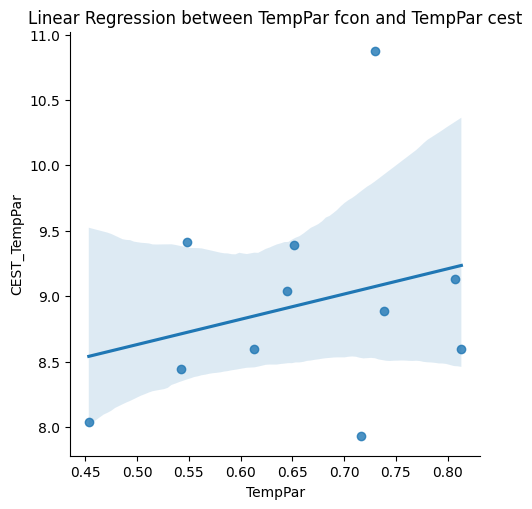

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


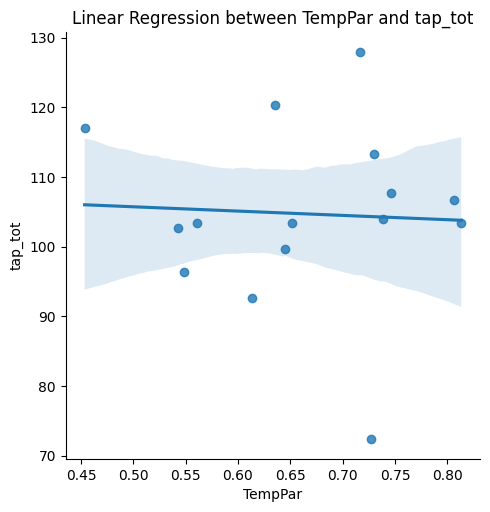

CEST_Default


/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


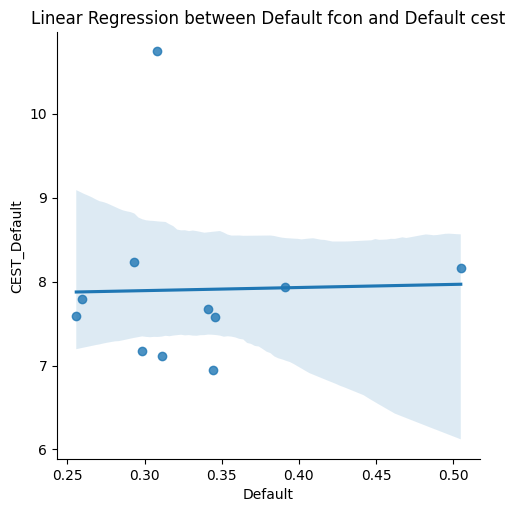

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


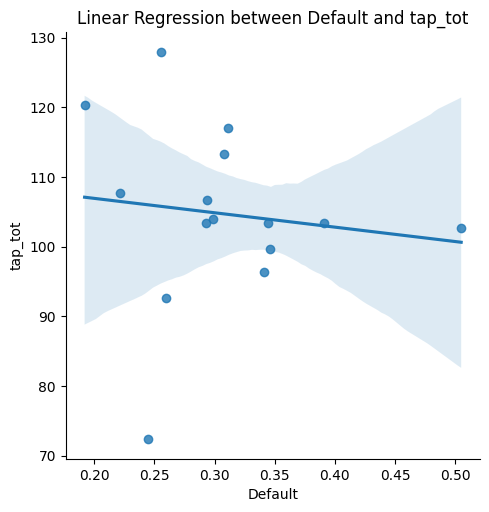

CEST_Vis


/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


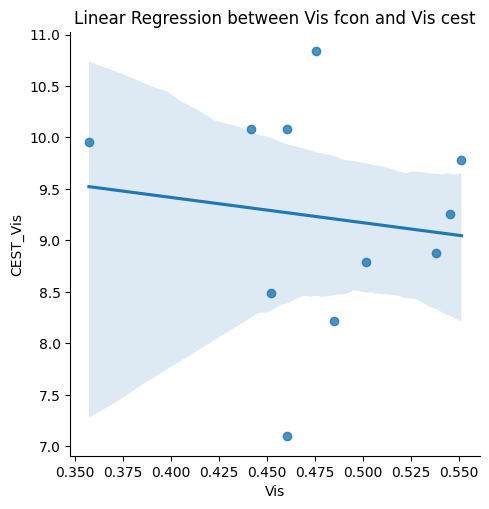

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


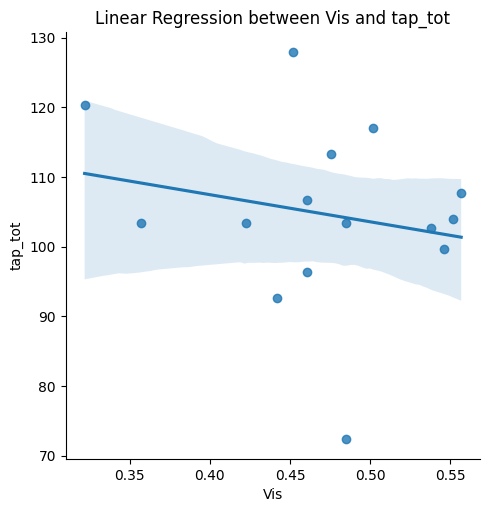

In [69]:
print(grp_df)
if run_grpanalysis:
    # Create a scatter plot with a linear regression line
    for network in networks:
        cestcol = "CEST_" + network
        print(cestcol)
        sns.lmplot(x=network, y=cestcol, data=grp_df)
        # Add labels and a title to the plot
        plt.xlabel(network)
        plt.ylabel(cestcol)
        plt.title('Linear Regression between ' + network + ' fcon and ' + network + ' cest')
        # Show the plot
        plt.show() 
        
        for CNB_score in CNB_scores:
            sns.lmplot(x=network, y='tap_tot', data=grp_df)
            # Add labels and a title to the plot
            plt.xlabel(network)
            plt.ylabel(CNB_score)
            plt.title('Linear Regression between ' + network + ' and ' + CNB_score)
            # Show the plot
            plt.show()       

            


### Network FCON 
Call fcon function and calculate network-level connectivity measures for subject and add  subject data to group file for future group analysis

In [51]:
#print(grp_df)


     BBLID Session  sex  age  race  ethnic  dateDiff   TempPar   Default  \
0   125511   10565  NaN  NaN   NaN     NaN       NaN  0.738944  0.298620   
1   116019   10078  NaN  NaN   NaN     NaN       NaN  0.813277  0.390910   
2    80557   10863  NaN  NaN   NaN     NaN       NaN  0.727461  0.244716   
3    94028    PNC3  NaN  NaN   NaN     NaN       NaN  0.635045  0.192065   
4    85369    PNC3  NaN  NaN   NaN     NaN       NaN  0.746480  0.221612   
5   106880   10302  NaN  NaN   NaN     NaN       NaN  0.613201  0.259672   
6    94288   11948  NaN  NaN   NaN     NaN       NaN  0.561186  0.292938   
7   121407    9257  NaN  NaN   NaN     NaN       NaN  0.453495  0.311155   
8   102041   10603  NaN  NaN   NaN     NaN       NaN  0.651965  0.344136   
9   119791   10082  NaN  NaN   NaN     NaN       NaN  0.716781  0.255729   
10   85743   10974  NaN  NaN   NaN     NaN       NaN  0.730235  0.307892   
11   83835   10777  NaN  NaN   NaN     NaN       NaN  0.806831  0.293335   
12   93734  